In [1]:
import time
import numpy as np
import pandas as pd
from sklearn import metrics
import pycaret
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import sMAPE, smape_loss

In [2]:
dataset = 'lynx'
# dataset = 'uschange'

fold = 3

if dataset == 'lynx':
    fh = np.arange(1,12) # 11 year lynx cycle
    seasonal_period = 11
elif dataset == 'uschange':
    fh = np.arange(1,9)  # Quarterly data (2 year forecast horizon)
    seasonal_period = 4  # Need to specify since no period index
else:
    raise ValueError("Incorect dataset")

PeriodIndex(['1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828',
             '1829', '1830',
             ...
             '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932',
             '1933', '1934'],
            dtype='period[A-DEC]', name='Period', length=114, freq='A-DEC')


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of Lynx trappings'>)

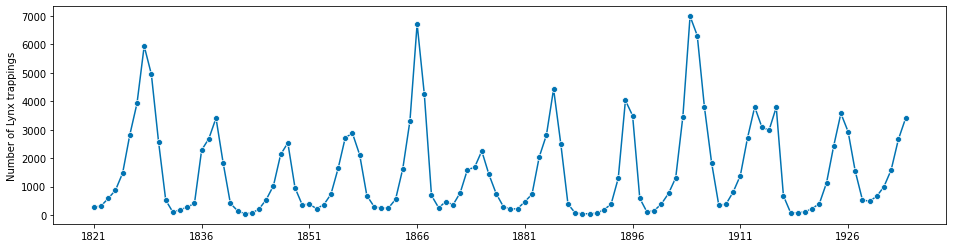

In [3]:
y = get_data(dataset, verbose=False)
print(y.index)
plot_series(y)

In [4]:
exp = TimeSeriesExperiment()
exp.setup(data=y, seasonal_period=seasonal_period, fh=fh, fold=fold, fold_strategy='expandingwindow', session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(114, 1)"
2,Missing Values,False
3,Transformed Train Set,"(103,)"
4,Transformed Test Set,"(11,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,CPU Jobs,-1
8,Use GPU,False
9,Log Experiment,False


In [5]:
y_train = exp.get_config("y_train")
# Internally split Keep len(fh) as test set
y_test = exp.get_config("y_test")

## Single Model

,smape,mape,mae,rmse
0,1.0351,3.0876,1020.2402,1706261.0561
1,0.8214,0.9027,1880.2035,7000441.7829
2,1.0198,5.9568,1280.0151,1789486.0381
Mean,0.9588,3.3157,1393.4863,3498729.6257
SD,0.0974,2.0696,360.1305,2476317.5110


0.6249

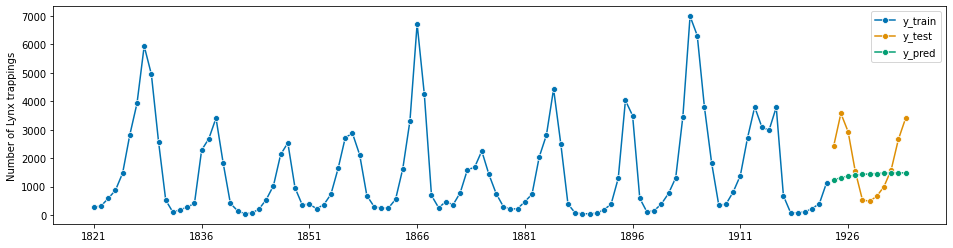

In [6]:
model = exp.create_model("arima")
y_pred = model.predict()
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
round(smape_loss(y_pred, y_test), 4)

In [7]:
# Random Grid Search
tuned_model = exp.tune_model(model, search_algorithm="random")
print(model)
print(tuned_model)

,smape,mape,mae,rmse
0,0.9047,0.9532,595.1582,644344.1868
1,0.7218,0.8169,1779.8230,6273162.6916
2,1.2966,12.7240,3460.6602,14448042.8605
Mean,0.9744,4.8314,1945.2138,7121849.9130
SD,0.2398,5.5812,1175.6675,5667199.5887


ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)
ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 11),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)


1.4679

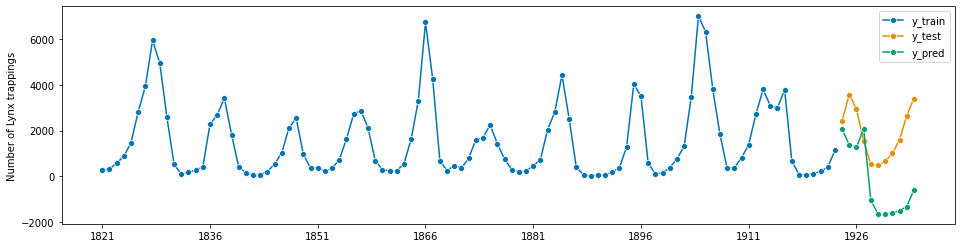

In [8]:
y_pred = tuned_model.predict()
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
round(smape_loss(y_pred, y_test), 4)

## Multiple Models

In [9]:
best_baseline_models = exp.compare_models(sort='smape', n_select=3)
best_baseline_models

,Model,smape,mape,mae,rmse,TT (Sec)
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7671,1.6400,1184.7423,2854715.7027,0.0367
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7686,1.6296,1184.0054,2853901.5759,0.0267
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7753,1.6457,1198.1753,2888198.0132,0.0333
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7753,1.6457,1198.1739,2888195.2093,0.0267
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7753,1.6457,1198.1753,2888198.0059,0.0367
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.7753,1.6457,1198.1728,2888192.9276,0.0267
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8186,2.1722,1181.4450,2772197.4496,0.1000
bats,BATS,0.9322,2.3835,1273.9151,3414600.9857,12.0467
tbats,TBATS,0.9322,2.3835,1273.9151,3414600.9857,24.7967
arima,ARIMA,0.9588,3.3157,1393.4863,3498729.6257,0.0367


[BaseCdsDt(degree=1, deseasonal_model='additive',
           regressor=LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
                               fit_intercept=True, fit_path=True, jitter=None,
                               max_iter=500, normalize=True, positive=False,
                               precompute='auto', random_state=42,
                               verbose=False),
           sp=1, window_length=10),
 BaseCdsDt(degree=1, deseasonal_model='additive',
           regressor=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
                                   compute_score=False, copy_X=True,
                                   fit_intercept=True, lambda_1=1e-06,
                                   lambda_2=1e-06, lambda_init=None, n_iter=300,
                                   normalize=False, tol=0.001, verbose=False),
           sp=1, window_length=10),
 BaseCdsDt(degree=1, deseasonal_model='additive',
           regressor=LinearRegression(copy_X

In [10]:
best_tuned_models = exp.tune_model(best_baseline_models[0], search_algorithm="random")
best_tuned_models

,smape,mape,mae,rmse
0,0.8427,2.9922,999.1747,1861418.7580
1,0.7666,0.5566,1721.7917,5558508.8090
2,1.1785,4.2562,1482.7481,3367464.4451
Mean,0.9293,2.6017,1401.2382,3595797.3374
SD,0.1790,1.5354,300.5847,1517941.7300


BaseCdsDt(degree=1, deseasonal_model='multiplicative',
          regressor=LassoLars(alpha=0.0019123708862553252, copy_X=True,
                              eps=1.0672476836323717e-05, fit_intercept=True,
                              fit_path=True, jitter=None, max_iter=500,
                              normalize=True, positive=False, precompute='auto',
                              random_state=42, verbose=False),
          sp=11, window_length=21)

0.6399

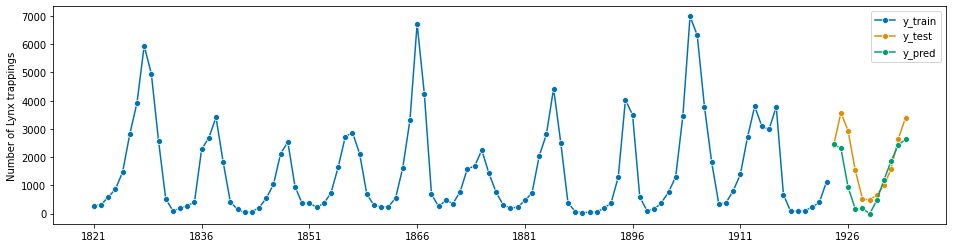

In [11]:
y_pred = best_tuned_models.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
round(smape_loss(y_pred, y_test), 4)

## Auto ARIMA

In [12]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
forecaster = AutoARIMA(sp=seasonal_period, suppress_warnings=True)
forecaster.fit(y_train)

AutoARIMA(D=None, alpha=0.05, d=None, error_action='warn',
          information_criterion='aic', max_D=1, max_P=2, max_Q=2, max_d=2,
          max_order=5, max_p=5, max_q=5, maxiter=50, method='lbfgs', n_fits=10,
          n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
          random_state=None, scoring='mse', scoring_args=None, seasonal=True,
          seasonal_test='ocsb', seasonal_test_args=None, sp=11, start_P=1,
          start_Q=1, start_p=2, start_params=None, ...)

0.7798

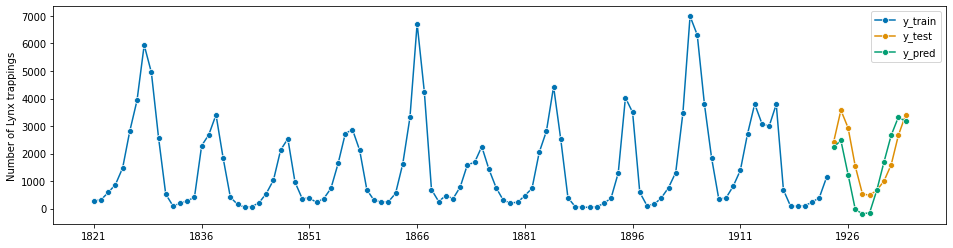

In [13]:
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
round(smape_loss(y_pred, y_test), 4)